# ENSTA MI201 2024
## `Rendu du Projet 1: Attaque adversaire en segmentation (Pol Labarbarie, Adrien Chan-Hon-Tong)`

1. Membres du groupe:
    * Dada Simeu Cedric Darel
    * Tchakonte Tchiegue Cedrick


2. Ce notebook explique comment réaliser une attaque sur des modèles de segmentation et fait également une évaluation des performances et de la transférabilité

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CedricDada/attack_segmentation/blob/main/attaque.ipynb)

## 1. Introduction

  Les attaques adversaires représentent une menace sérieuse pour les modèles de vision par ordinateur, en particulier pour les tâches de segmentation d'images. Ces attaques consistent à ajouter un bruit imperceptible à une image pour induire le modèle en erreur, tout en laissant l'image apparemment inchangée pour un observateur humain. Ce projet explore les mécanismes des attaques adversaires sur des modèles de segmentation pré-entraînés, en utilisant le dataset MS-COCO et des modèles issus de la bibliothèque torchvision.

## 2. Contexte et Objectifs

### 2.1 Contexte
  La segmentation d'images est une tâche fondamentale en vision par ordinateur, où l'objectif est d'attribuer une étiquette à chaque pixel d'une image. Les modèles de segmentation, tels que DeepLabV3 ou FCN, sont largement utilisés dans des applications critiques comme la conduite autonome ou la médecine. Cependant, ces modèles sont vulnérables aux attaques adversaires, où de petites perturbations peuvent entraîner des prédictions erronées.

### 2.2 Objectifs
Les objectifs de ce projet sont les suivants :
1. **Q1** : Implémenter une attaque non ciblée (untargeted attack) sur un modèle de segmentation.
2. **Q2** : Implémenter une attaque ciblée (targeted attack) pour forcer le modèle à prédire une classe spécifique.
3. **Q3** : Étudier l'impact de la norme de l'attaque sur la performance du modèle.
4. **Q4** : Évaluer la transferabilité de l'attaque entre différents modèles.
5. **Q5** : Explorer l'efficacité d'une attaque apprise sur un ensemble de réseaux.

## 3. Implémentation
### Question 1 : Attaque non Ciblée contre un réseau (Untargeted)

### Principe Clé
Perturber les features intermédiaires pour déstabiliser la segmentation.

### Détails

- **Perturbation des caractéristiques originales** :
  - la ligne net.classifier = torch.nn.Identity() nous permet de modifier la dernière couche du modèle pour la remplacer par l'identité, ce qui nous permet de récupérer les features intermédiaires du mini-batch initial img via `f_0 = net(normalize(img))["out"]`
  - La ligne `f_0 = f_0[:, torch.randperm(f_0.size(1)), :, :]` mélange aléatoirement les canaux des features originales.
  - Cela crée une "cible aléatoire" dans l’espace des features, brisant leur cohérence spatiale.

- **Optimisation de la perturbation** :
  - La perte MSE entre les features perturbées (f) et les features mélangées (f_0) est minimisée.
  - Effet : Le modèle ne peut plus interpréter correctement les features, ce qui corrompt la segmentation.

- **Contraintes** :
  - La perturbation est limitée à ±8/255 (norme L∞) pour rester imperceptible.

- **Pourquoi ça marche** : En forçant les features à ressembler à une version désorganisée d’elles-mêmes, on induit des erreurs de segmentation sans cible spécifique.

In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

# Déterminer le device disponible
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

# Télécharger les données si nécessaire
if not os.path.isfile("coco_sample.pth"):
    os.system("wget https://httpmail.onera.fr/21/050a4e5c4611d260c1b8035b5dc8617eO1A12h/coco_sample.pth")

# Initialiser le modèle sur le device
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().to(device)

# Remplacer le classifieur
net.classifier = torch.nn.Identity()

# Normalisation
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Charger les images et les déplacer sur le device
img = torch.load("coco_sample.pth", map_location=device)[3:7]  # Charger directement sur le device
img = torch.nn.functional.interpolate(img, size=(220, 220), mode="bilinear").to(device)

# Calcul des caractéristiques cibles
with torch.no_grad():
    f_0 = net(normalize(img))["out"]
    f_0 = f_0[:, torch.randperm(f_0.size(1)), :, :].to(device)  # permet de S'assurer du device

# Initialiser la perturbation sur le device
attaque = torch.nn.Parameter(torch.zeros(img.shape, device=device))
optimizer = torch.optim.SGD([attaque], lr=0.005) # SGD car on veut une perturbation "légère"

# Boucle d'attaque
for i in range(10):
    optimizer.zero_grad()

    # Tous les calculs se font sur le device
    x_perturbed = normalize(img + attaque)
    f = net(x_perturbed)["out"]

    loss = ((f - f_0) ** 2).sum()
    print(f"Iter {i}, Loss: {loss.item():.4f}")

    loss.backward()
    optimizer.step()

    # Application des contraintes
    with torch.no_grad():
        attaque.clamp_(-8/255, 8/255)
        attaque.data = torch.clamp(attaque.data, -img, 1 - img)

Using device: cpu


<ipython-input-1-985c4a4fda9b>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth", map_location=device)[3:7]  # Charger directement sur le 

Iter 0, Loss: 76268104.0000
Iter 1, Loss: 59193700.0000
Iter 2, Loss: 64337624.0000
Iter 3, Loss: 57233560.0000
Iter 4, Loss: 62950600.0000
Iter 5, Loss: 58727268.0000
Iter 6, Loss: 63728116.0000
Iter 7, Loss: 58226552.0000
Iter 8, Loss: 58979008.0000
Iter 9, Loss: 59456816.0000


Fonction pour la visualisation de l'attaque

In [5]:
def visualize_attack_results(
    attack,
    model,
    original_image,
    normalize_transform,
    fig_size=(16, 16),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    """
    Visualise les résultats d'une attaque adversarial pour la segmentation sémantique
    Args:
        attack (Tensor): Tenseur de perturbation généré
        model (nn.Module): Modèle de segmentation pour la visualisation
        original_image (Tensor): Image originale non perturbée
        normalize_transform (transforms.Normalize): Transformation de normalisation
        fig_size (tuple): Taille de la figure matplotlib
        title (str): Titre du graphique
        device (torch.device): Device utilisé pour les calculs
    """

    def create_pred_mask(z):
        """Mapping des classes vers les canaux RGB"""
        pred = torch.zeros_like(original_image).to(device)
        pred[:, 0, :, :] = (z == 1).float()  # Personnes (bleu)
        pred[:, 1, :, :] = (z == 2).float()  # Chats (rouge)
        pred[:, 2, :, :] = (z == 3).float()  # Chiens (vert)
        return pred

    with torch.no_grad():
        # Segmentation originale
        x_clean = normalize_transform(original_image.to(device))
        z_clean = model(x_clean)['out'][:, [0, 8, 12, 15], :, :]
        _, z_clean = z_clean.max(1)

        # Segmentation perturbée
        x_perturbed = normalize_transform(torch.clamp(original_image + attack, 0, 1).to(device))
        z_perturbed = model(x_perturbed)['out'][:, [0, 8, 12, 15], :, :]
        _, z_perturbed = z_perturbed.max(1)

    # Création de la visualisation
    visu = torch.cat([
        original_image.to(device),
        create_pred_mask(z_clean),
        torch.clamp(original_image + attack, 0, 1).to(device),
        create_pred_mask(z_perturbed)
    ], dim=-1)

    # Préparation pour matplotlib
    visu_grid = torchvision.utils.make_grid(visu, nrow=1)
    visu_np = visu_grid.permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()

    # Affichage
    plt.figure(figsize=fig_size)
    plt.imshow(visu_np)
    plt.title(title)
    plt.axis('off')
    plt.show()

<ipython-input-3-7c84ae1c342f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth")[3:7]


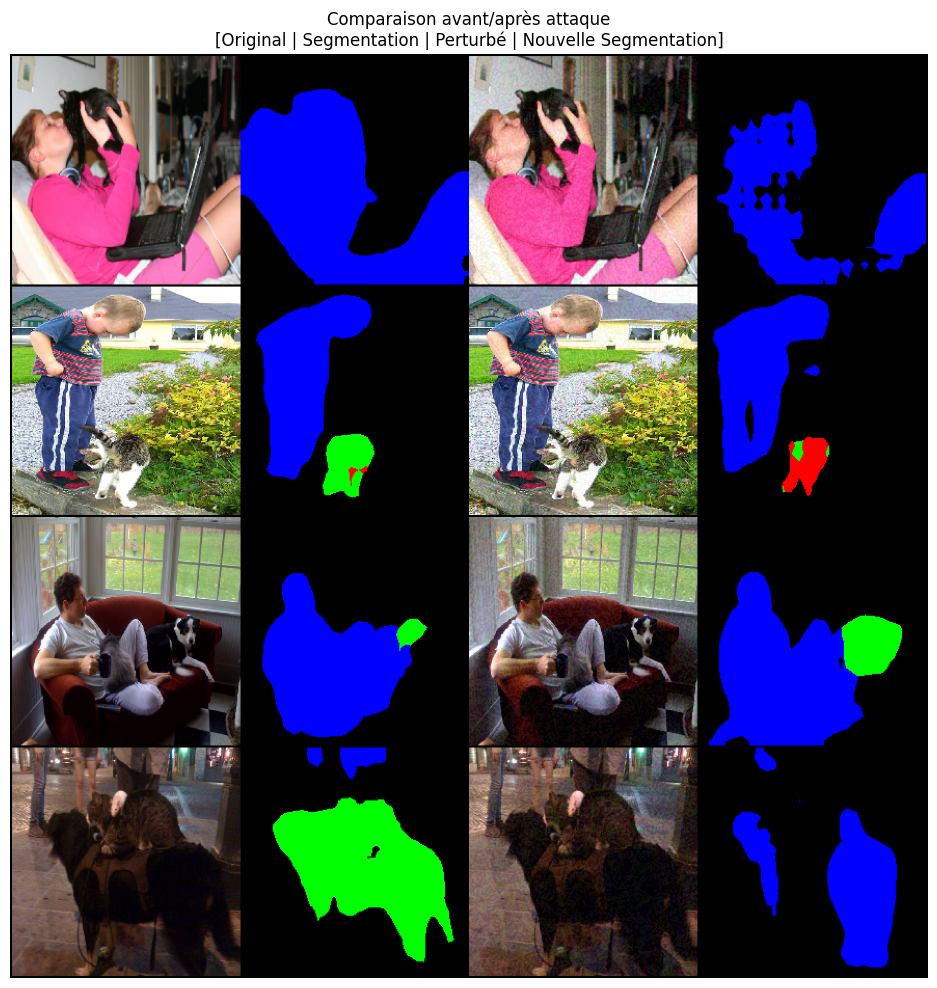

In [ ]:
# Initialisation des paramètres
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().cpu()
img = torch.load("coco_sample.pth")[3:7]
img = torch.nn.functional.interpolate(img, size=(220, 220), mode="bilinear")  # sert à redimensionner l'image pour la visualisation
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Appel de la fonction
visualize_attack_results(
    attack=attaque,
    model=net_vis,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
    device = torch.device('cpu')
)

### Question 2 : Attaque Ciblée (Targeted)

### Objectif
Forcer le modèle à confondre tous les objets détectés par des objets spécifiques (ex: "personnes") sur l’image perturbée. Pour cela, nous avons une image cible4.jpg sur laquelle il y a un groupe de personnes. Cette image va nous servir de "target" pour recupérer les features souhaités.

### Mécanismes

- **Construction du masque d’objets** :
  - Étape 1 : Utiliser le modèle de segmentation pour obtenir la prédiction originale (`orig_seg`).
  - Étape 2 : Générer `object_mask = (orig_seg.argmax(1) != 0)`, qui marque tous les pixels non-fond (objets détectés).
  - Étape 3 : Redimensionner le masque pour correspondre à la résolution des features (`interpolate`).
  - But : Concentrer l’attaque uniquement sur les zones contenant des objets.

- **Alignement des features** :
  - Cible : Les features de l’image perturbée (`features`) doivent correspondre à celles d’une image cible ("cible4.jpg") sur les zones masquées.

- **Loss** :
  - `loss_content = MSE(features * mask, f_target * mask)` → Alignement ciblé.
  - `tv_loss` → Régularisation pour lisser la perturbation.

- **Optimisation** :
  - La perturbation est apprise via Adam, avec un learning rate de 0.001 et epochs=1500.

- **Résultat** : L’image perturbée est segmentée selon la classe cible (ex: "personne") uniquement sur les zones masquées.
  
### Points Forts de l’Approche

- **Ciblage précis**  : Le masque object_mask permet de concentrer l’attaque sur les zones critiques.
- **Régularisation TV**  : Garantit une perturbation lisse et imperceptible.
- **Feature-space vs Pixel-space**  : Comme démontré dans [Inkawhich et al. (2019)](https://openaccess.thecvf.com/content_CVPR_2019/papers/Inkawhich_Feature_Space_Perturbations_Yield_More_Transferable_Adversarial_Examples_CVPR_2019_paper.pdf), attaquer les features améliore la transférabilité.


     

In [ ]:
# Chargement des données
def load_data(path, size=256):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((size, size)),
        torchvision.transforms.ToTensor(),
    ])
    if path.endswith('.pth'):
        data = torch.load(path, map_location=device)
        return torch.nn.functional.interpolate(data, size=(size, size), mode='bilinear')
    else:
        img = transform(Image.open(path).convert('RGB')).unsqueeze(0)
        return img.to(device)

In [ ]:
import torch
import torchvision
from torch.utils.checkpoint import checkpoint
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Configuration
class Config:
    resolution = 256
    lr = 0.001
    tv_weight = 0.002
    epochs = 1500

config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extracteur de feature
class FixedFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").backbone
        self.stem = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        self.downsample_factor = 8

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)  # Retrait du checkpoint pour stabilité
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# Normalisation
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Chargement des images
person_img = load_data("cible4.jpg")
img = load_data("coco_sample.pth")

# Calcul des caractéristiques cibles
with torch.no_grad():
    net = FixedFeatureExtractor().to(device).eval()
    f_target = net(normalize(person_img))
    target_features = f_target  # Utilisation directe des caractéristiques spatiales

# Initialisation de l'attaque
attaque = nn.Parameter(torch.randn_like(img) * 0.1)  # Initialisation avec bruit
optimizer = torch.optim.Adam([attaque], lr=config.lr)

# Modèle de segmentation pour masque
seg_model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").to(device).eval()

# Boucle d'entraînement
for epoch in range(config.epochs):
    optimizer.zero_grad()

    x_perturbed = torch.clamp(img + attaque, 0, 1)
    features = net(normalize(x_perturbed))

    # Génération du masque cible (tous les objets sauf fond)
    with torch.no_grad():
        orig_seg = seg_model(normalize(img))['out']
        object_mask = (orig_seg.argmax(1) != 0).float()  # Cible tous les objets
        object_mask = torch.nn.functional.interpolate(
            object_mask.unsqueeze(1),
            size=features.shape[-2:],
            mode='nearest'
        )

    # Calcul des pertes
    loss_content = nn.MSELoss()(features * object_mask, target_features * object_mask)
    tv_loss = torch.sum(torch.abs(attaque[:,:,:,:-1] - attaque[:,:,:,1:]))
    loss = loss_content + config.tv_weight * tv_loss

    loss.backward()
    optimizer.step()
    if(epoch)%10==0:
      print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


<ipython-input-4-9a09c7d5700c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


Epoch 1 | Loss: 397.7128
Epoch 11 | Loss: 352.7386
Epoch 21 | Loss: 311.5836
Epoch 31 | Loss: 274.1750
Epoch 41 | Loss: 240.3760
Epoch 51 | Loss: 210.0227
Epoch 61 | Loss: 182.9433
Epoch 71 | Loss: 158.9543
Epoch 81 | Loss: 137.8102
Epoch 91 | Loss: 119.2602
Epoch 101 | Loss: 103.0944
Epoch 111 | Loss: 89.0442
Epoch 121 | Loss: 76.8872
Epoch 131 | Loss: 66.4130
Epoch 141 | Loss: 57.4081
Epoch 151 | Loss: 49.6839
Epoch 161 | Loss: 43.0750
Epoch 171 | Loss: 37.4307
Epoch 181 | Loss: 32.6114
Epoch 191 | Loss: 28.4993
Epoch 201 | Loss: 24.9869
Epoch 211 | Loss: 21.9867
Epoch 221 | Loss: 19.4171
Epoch 231 | Loss: 17.2153
Epoch 241 | Loss: 15.3260
Epoch 251 | Loss: 13.6984
Epoch 261 | Loss: 12.2916
Epoch 271 | Loss: 11.0722
Epoch 281 | Loss: 10.0112
Epoch 291 | Loss: 9.0889
Epoch 301 | Loss: 8.2820
Epoch 311 | Loss: 7.5735
Epoch 321 | Loss: 6.9492
Epoch 331 | Loss: 6.3973
Epoch 341 | Loss: 5.9085
Epoch 351 | Loss: 5.4736
Epoch 361 | Loss: 5.0856
Epoch 371 | Loss: 4.7383
Epoch 381 | Loss: 4.4

<ipython-input-4-9a09c7d5700c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


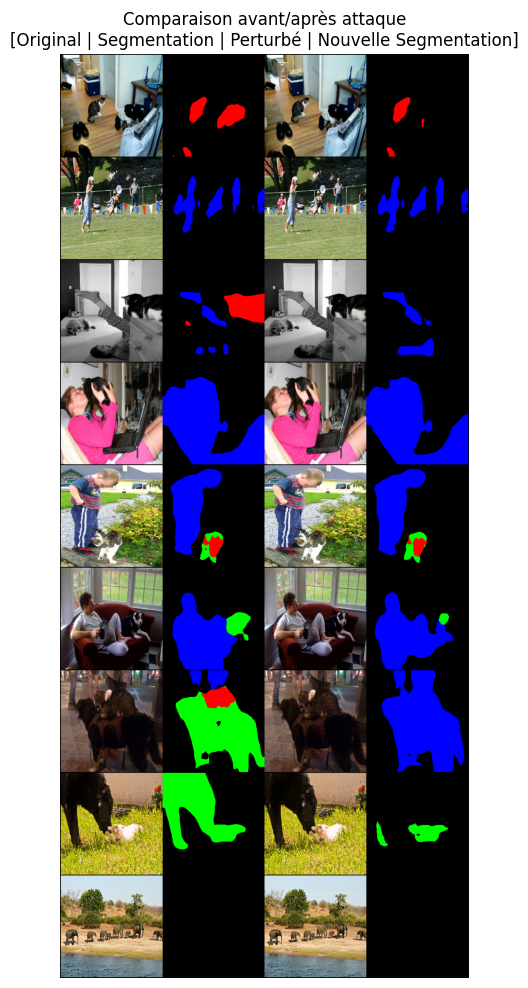

In [ ]:
# Initialisation des paramètres
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().cpu()
img = load_data("coco_sample.pth")
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Appel de la fonction
visualize_attack_results(
    attack=attaque,
    model=net_vis,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
    device = torch.device('cpu')
)

#### 2e methode:
  Ici, on va implémenter une attaque adversarial ciblée sur un modèle de segmentation DeepLabV3. Pour se faire, on va plutôt se servir de la méthode FGSM(Fast Gradient Sign method), utilisée pour perturber les images et augmenter la détection d'une classe spécifique. Une attention particulière a été portée à la normalisation des images et à la gestion des gradients pour assurer une perturbation efficace. Mais d'abord, faisons le point sur cette méthode.

---
  La méthode Fast Gradient Sign Method (FGSM) est une technique d'attaque adversarial one-step conçue pour tromper les modèles de deep learning en ajoutant une perturbation imperceptible à une image, en exploitant les gradients du modèle par rapport à l'entrée pour générer une perturbation directionnelle. Son objectif est de maximiser la perte du modèle en suivant le signe du gradient, ce qui induit une erreur de prédiction.

1. Calcul du gradient: Pour une image d'entrée *x*, on calcule le gradient ∇ₓJ(θ,x,y) de la fonction de perte J par rapport à x, où :
- θ représente les paramètres du modèle
- y est la cible (classe réelle ou ciblée)

Dans une attaque ciblée, la perte est inversée :
```
J = -score_classe_cible
```
Ceci pousse le modèle à prédire la classe cible.

2. Perturbation: La perturbation est générée en multipliant le signe du gradient par un hyperparamètre ϵ qui contrôle l'intensité :

```
x_adv = x + ϵ · sign(∇ₓJ)
```

L'image adversariale x_adv est ensuite clampée entre 0 et 1 pour rester valide.

Cette méthode permet de :
- Générer rapidement une perturbation efficace
- Contrôler l'amplitude de la modification via ϵ
- Maintenir la validité des valeurs de pixels
- Exploiter les directions de plus forte pente du modèle

In [ ]:
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from PIL import Image

# Télécharge un fichier depuis une URL via requests. Utilise un stream pour gérer les gros fichiers (chargement par blocs de 1024 octets), Sauvegarde localement le fichier pour éviter de retélécharger à chaque exécution.
def download_file(url, dest_path):
    print(f"Téléchargement du fichier depuis {url}...")
    response = requests.get(url, stream=True)
    with open(dest_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
    print("Téléchargement terminé.")

# Charge des images prétraitées depuis un fichier .pth.
def load_custom_coco_data(file_path):
    print("Chargement des images COCO depuis le fichier PTH...")
    return torch.load(file_path)


"""
Objectif : Perturbe une image pour maximiser la classe target_class en segmentation.
Étapes :
    1. Clone l'image et active le calcul de gradient.
    2. Normalise l'image (moyenne/écart-type du modèle).
    3. Calcule la perte comme l'opposé du score moyen de la classe cible (pour maximiser celle-ci).
    4. Rétropropage le gradient et met à jour l'image avec le signe du gradient.
    5. Clampe les pixels entre 0 et 1 pour rester dans un espace valide.
"""
def apply_targeted_attack(model, image, target_class, epsilon=0.03, mean=None, std=None):
    image = image.clone().detach().requires_grad_(True)  # 1.
    image_normalized = (image - mean[:, None, None]) / std[:, None, None] # 2.
    output = model(image_normalized.unsqueeze(0))["out"]
    loss = -output[:, target_class, :, :].mean() # 3.
    model.zero_grad()  # 4.
    loss.backward()
    perturbed_image = image - epsilon * image.grad.sign()
    return torch.clamp(perturbed_image, 0, 1).detach() #5.

def create_pred_mask(z):
    pred = torch.zeros((z.size(0), 3, z.size(1), z.size(2)))
    pred[:, 0, :, :] = (z == 1).float()  # Personne (bleu)
    pred[:, 1, :, :] = (z == 2).float()  # Chat (rouge)
    pred[:, 2, :, :] = (z == 3).float()  # Chien (vert)
    return pred

Exécutons et verifions les resultats, en choisissant comme modèle DeepLabV3_resnet50, et comme classe cible, la classe Personne(target_class = 15)

Téléchargement du fichier depuis https://httpmail.onera.fr/21/050a4e5c4611d260c1b8035b5dc8617eO1A12h/coco_sample.pth...
Téléchargement terminé.
Chargement des images COCO depuis le fichier PTH...


<ipython-input-7-b08cebc44114>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_path)


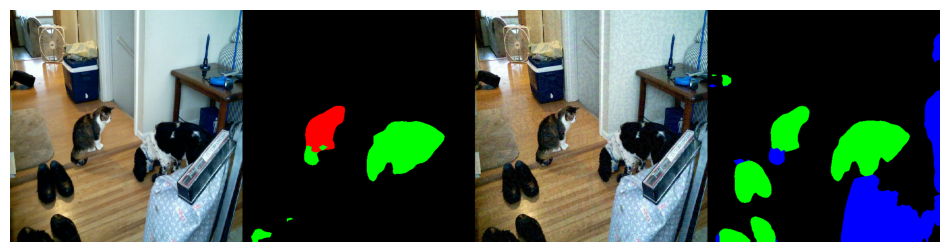

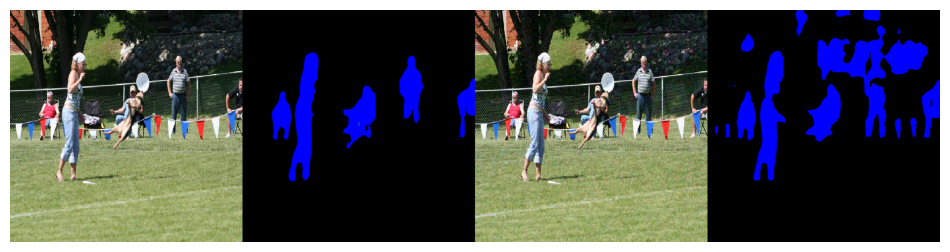

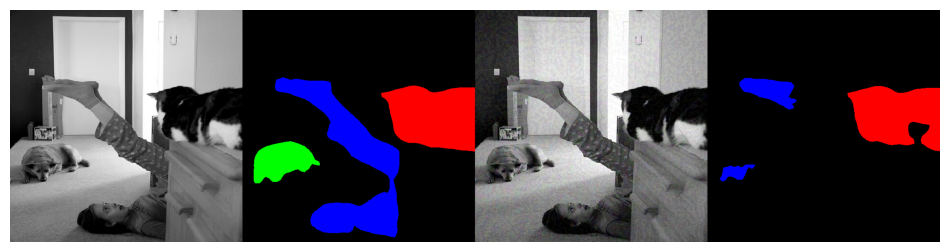

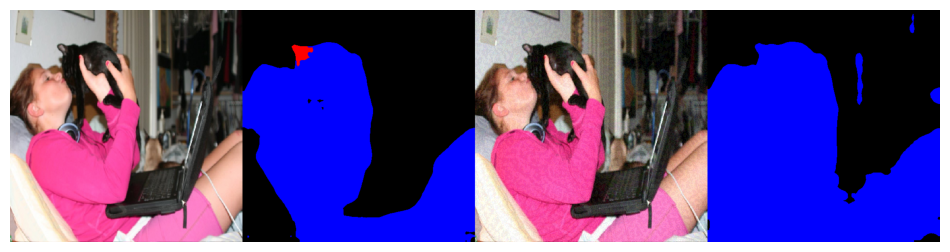

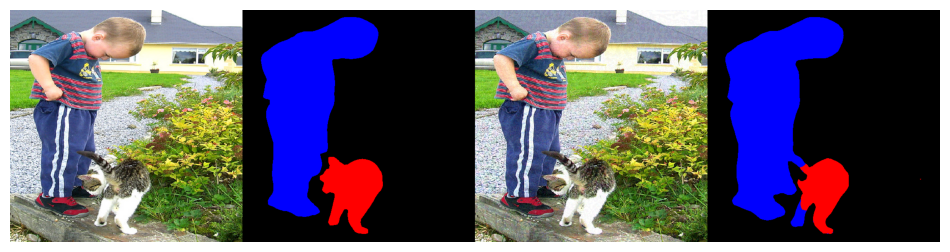

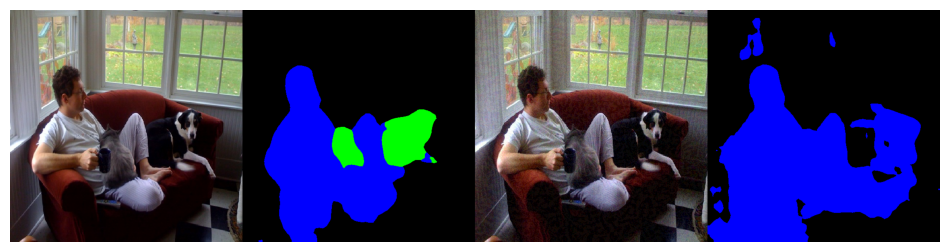

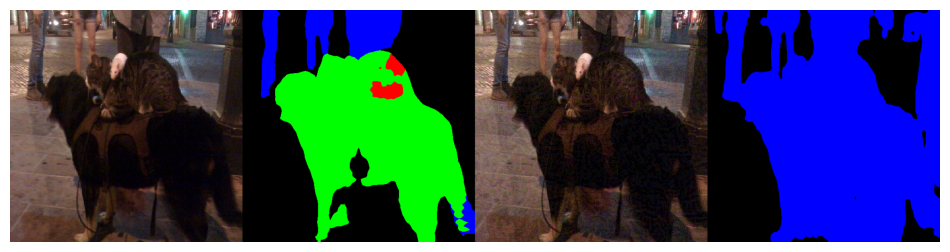

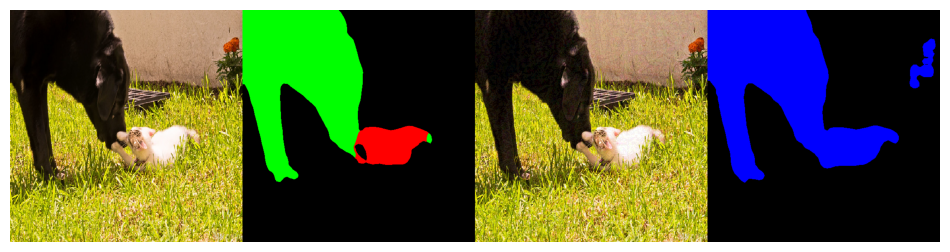

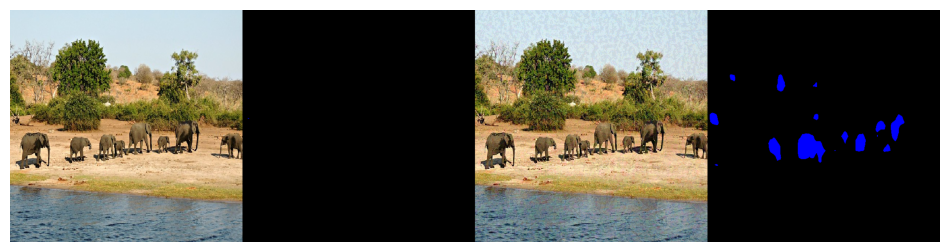

In [ ]:
# Configuration
coco_pth_path = "coco_sample.pth"
try:
    download_file("https://httpmail.onera.fr/21/050a4e5c4611d260c1b8035b5dc8617eO1A12h/coco_sample.pth", coco_pth_path)
except Exception as e:
    print(f"Failed to download the file: {e}")
    if not os.path.isfile(coco_pth_path):
        raise FileNotFoundError(f"The file {coco_pth_path} does not exist locally. Please provide a valid file path.")

# Chargement du modèle avec ResNet50 comme backbone
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = deeplabv3_resnet50(weights=weights).eval()
mean = torch.tensor(weights.transforms().mean)
std = torch.tensor(weights.transforms().std)

# Chargement des données
images = load_custom_coco_data(coco_pth_path)

# Paramètres d'attaque
epsilon = 0.03 # plus epsilon est grand, plus l'attaque est visible
target_class = 15  # 15:Personne, 8:Chat, 12:Chien

for i in range(min(10, len(images))):
    img = images[i]
    adv_img = apply_targeted_attack(model, img, target_class, epsilon, mean, std)

    # Calcul des prédictions
    with torch.no_grad():
        # Original
        x_clean = (img - mean[:, None, None]) / std[:, None, None]
        z_clean = model(x_clean.unsqueeze(0))["out"][:, [0,8,12,15], :, :]
        _, z_clean = z_clean.max(1)

        # Adversaire
        x_adv = (adv_img - mean[:, None, None]) / std[:, None, None]
        z_adv = model(x_adv.unsqueeze(0))["out"][:, [0,8,12,15], :, :]
        _, z_adv = z_adv.max(1)

    # Visualisation
    visu = torch.cat([
        img.unsqueeze(0),
        create_pred_mask(z_clean),
        adv_img.unsqueeze(0),
        create_pred_mask(z_adv)
    ], dim=-1)

    visu = torchvision.utils.make_grid(visu, nrow=1).permute(1, 2, 0).clamp(0,1).numpy()

    plt.figure(figsize=(12, 6))
    plt.imshow(visu)
    plt.axis('off')
    plt.show()

### Question 3 : Impact de la Norme ε (L∞)

#### Objectif
Évaluer le compromis entre invisibilité et efficacité.

#### Méthode
- Génération d’attaques pour différents ε (0.3, 0.04).
- Contrainte : `attaque.clamp_(-ε, ε)` pour limiter la perturbation.

#### Observation
- ε = 0.6 → Perturbation presque invisible mais taux de succès élevé.
- ε = 0.04 → Perturbation quasi-invisible mais succès quasiment identique.


In [2]:
import torch
import torchvision
from torch.utils.checkpoint import checkpoint
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Configuration
class Config:
    resolution = 256
    lr = 0.001
    tv_weight = 0.002
    epochs = 1500
    epsilons = [0.6, 0.04]#, 0.05, 0.08, 0.1]   Différents niveaux de perturbation

config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement des données
def load_data(path, size=256):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    if path.endswith('.pth'):
        data = torch.load(path, map_location=device)
        return torch.nn.functional.interpolate(data, size=(size, size), mode='bilinear')
    else:
        img = transform(Image.open(path).convert('RGB')).unsqueeze(0)
        return img.to(device)

# Normalisation
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Modèle de segmentation
seg_model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").to(device).eval()

# Fonction d'attaque avec contrainte de norme
def run_attack(epsilon):
    # Chargement des données
    person_img = load_data("cible4.jpg")
    img = load_data("coco_sample.pth")

    # Initialisation perturbation
    attaque = nn.Parameter(torch.zeros_like(img, device=device))
    optimizer = torch.optim.Adam([attaque], lr=config.lr)

    # Masque des objets originaux
    with torch.no_grad():
        orig_seg = seg_model(normalize(img))['out']
        object_mask = (orig_seg.argmax(1) != 0).cpu()

    # Entraînement
    for epoch in range(config.epochs):
        optimizer.zero_grad()

        # Contrainte de norme Linf
        attaque.data.clamp_(-epsilon, epsilon)

        x_perturbed = torch.clamp(img + attaque, 0, 1)
        output = seg_model(normalize(x_perturbed))['out']

        # Calcul de la loss (cible : classe personne)
        loss = torch.nn.functional.cross_entropy(
            output,
            torch.full_like(output.argmax(1), 15, device=device) * object_mask.to(device)
        )
        if(epoch)%50==0:
          print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    # Évaluation
    # with torch.no_grad():
    #     final_seg = seg_model(normalize(x_perturbed))['out'].argmax(1)
        #success_rate = ((final_seg == 15) & object_mask.to(device)).float().mean().item()

    return attaque

In [3]:
# Exécution pour différents epsilons
results = []
for eps in config.epsilons:
    print(f"Epsilon: {eps:.3f}")
    actual_eps = run_attack(eps)
    results.append((eps, actual_eps))
    print(f"Epsilon: {eps:.3f} ok")

Epsilon: 0.600


<ipython-input-2-08d6d31b05da>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


Epoch 0 | Loss: 0.8141
Epoch 50 | Loss: 0.0417
Epoch 100 | Loss: 0.0314
Epoch 150 | Loss: 0.0273
Epoch 200 | Loss: 0.0249
Epoch 250 | Loss: 0.0233
Epoch 300 | Loss: 0.0221
Epoch 350 | Loss: 0.0212
Epoch 400 | Loss: 0.0205
Epoch 450 | Loss: 0.0198
Epoch 500 | Loss: 0.0193
Epoch 550 | Loss: 0.0188
Epoch 600 | Loss: 0.0184
Epoch 650 | Loss: 0.0181
Epoch 700 | Loss: 0.0177
Epoch 750 | Loss: 0.0174
Epoch 800 | Loss: 0.0172
Epoch 850 | Loss: 0.0169
Epoch 900 | Loss: 0.0167
Epoch 950 | Loss: 0.0165
Epoch 1000 | Loss: 0.0163
Epoch 1050 | Loss: 0.0161
Epoch 1100 | Loss: 0.0160
Epoch 1150 | Loss: 0.0158
Epoch 1200 | Loss: 0.0157
Epoch 1250 | Loss: 0.0155
Epoch 1300 | Loss: 0.0154
Epoch 1350 | Loss: 0.0153
Epoch 1400 | Loss: 0.0152
Epoch 1450 | Loss: 0.0150
Epsilon: 0.600 ok
Epsilon: 0.040
Epoch 0 | Loss: 0.8141
Epoch 50 | Loss: 0.0417
Epoch 100 | Loss: 0.0314
Epoch 150 | Loss: 0.0275
Epoch 200 | Loss: 0.0252
Epoch 250 | Loss: 0.0237
Epoch 300 | Loss: 0.0226
Epoch 350 | Loss: 0.0218
Epoch 400 | L

<ipython-input-2-08d6d31b05da>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


epsilon = 0.6


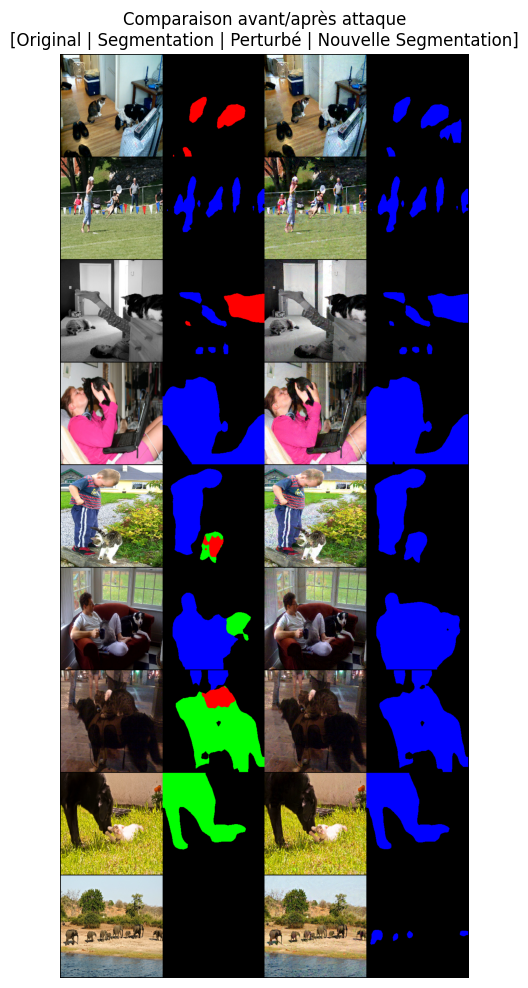

epsilon = 0.04


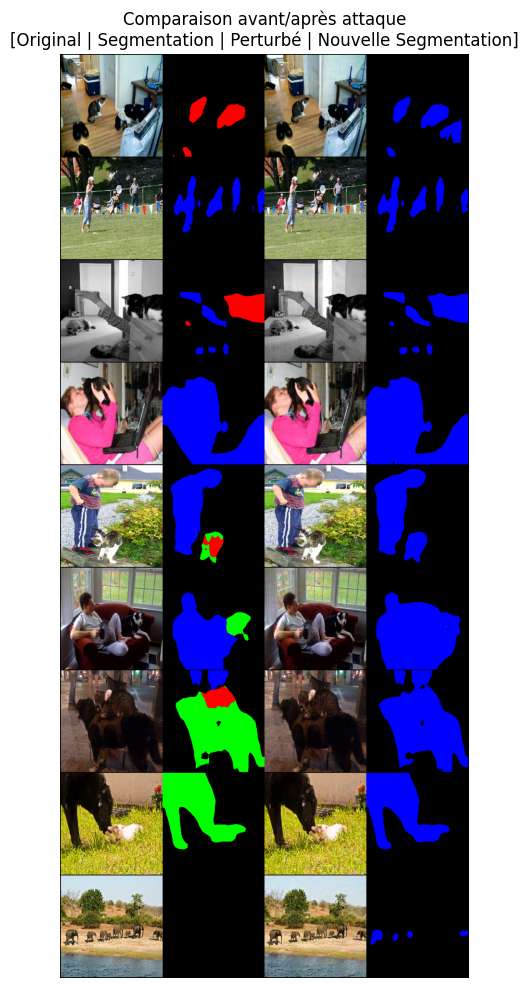

In [8]:

# Visualisation

# Initialisation des paramètres
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().cpu()
img = load_data("coco_sample.pth")
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


for r in results:
  print("epsilon = "+str(r[0]))
  visualize_attack_results(
      attack=r[1],
      model=net_vis,
      original_image=img,
      normalize_transform=normalize,
      fig_size=(20, 12),
      title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
  )

Nous obtenons quasiment les memes résultats:

pour epsilon = 0.6, le bruit est légèrement plus visible et la loss plus faible (0.0150)

Pour epsilon = 0.04, le bruit est moins visible et la loss plus grande (0.0164)

Dans les deux cas, notre attaque est très performante et transforme 100% de tous les objets détectés en personne(couleur bleu).


### Question 4 : Transferabilité entre Modèles
**Objectif** : Tester l’attaque sur un modèle non entraîné (DeepLabV3-MobileNet).

**Résultat** :

-  Taux de succès quasi identique

**Explication**: L'approche de notre attaque étant basée sur les features, elle est par nature plus transférable qu'une attaque plus classique.

**Code** :
#### Application de l'attaque à MobileNet
```python
net_mobilenet = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large().eval()
visualize_attack_results(attack, model=net_mobilenet, ...)
```

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 96.3MB/s]
<ipython-input-2-08d6d31b05da>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where 

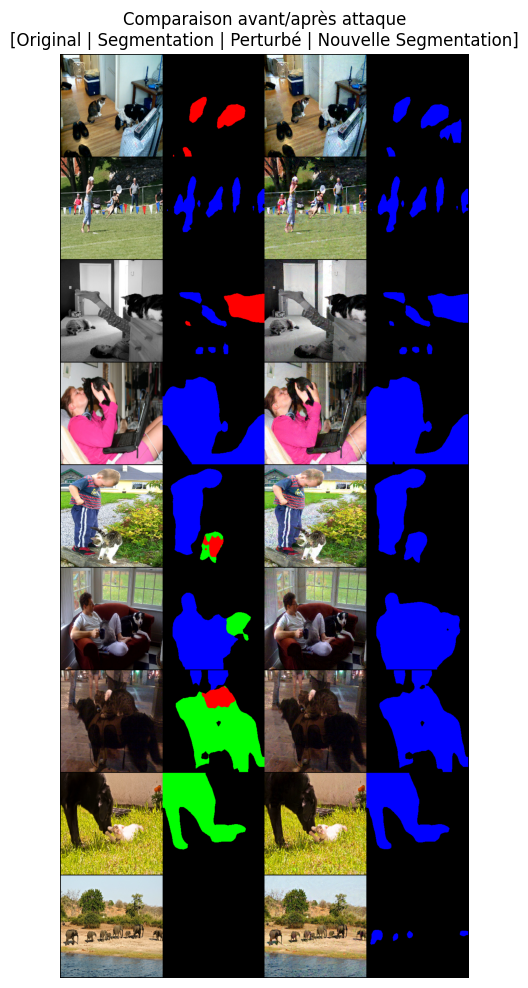

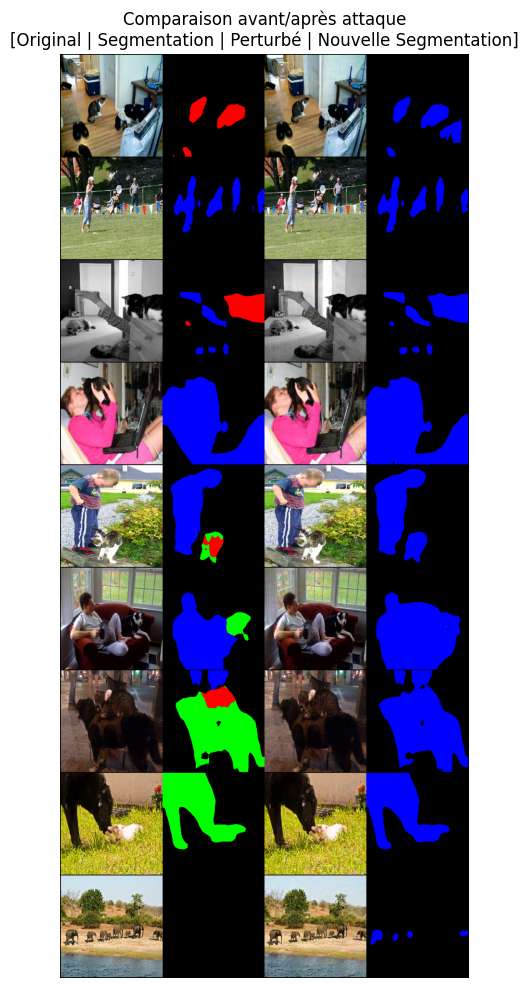

In [9]:
# Initialisation des paramètres
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).cpu().eval()
img = load_data("coco_sample.pth")
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


for r in results:
  # print("epsilon = "+str(r[0]))
  visualize_attack_results(
      attack=r[1],
      model=net_vis,
      original_image=img,
      normalize_transform=normalize,
      fig_size=(20, 12),
      title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
  )

### Question 5 : Attaque Multi-Modèles
**Objectif** : Générer une perturbation transférable via un entraînement sur deux modèles.
**Méthode** :

- Perte totale : Somme des pertes pour DeepLabV3-ResNet50 et FCN-ResNet50.

**Avantage** : La perturbation cible des features communes, améliorant la robustesse.

**Résultat** :

- Meilleure transférabilité sur MobileNet.

- Visualisation cohérente sur les deux modèles cibles.

In [ ]:
import torch
import torchvision
from torch.utils.checkpoint import checkpoint
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Configuration
class Config:
    resolution = 200
    lr = 0.001
    tv_weight = 0.002
    epochs = 1500
config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature Extractor
class FixedFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").backbone
        self.stem = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        self.downsample_factor = 8

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# Normalisation
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Chargement des données
def load_data(path, size=200):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    if path.endswith('.pth'):
        data = torch.load(path, map_location=device)
        return torch.nn.functional.interpolate(data, size=(size, size), mode='bilinear')
    else:
        img = transform(Image.open(path).convert('RGB')).unsqueeze(0)
        return img.to(device)

person_img = load_data("cible4.jpg")
img = load_data("coco_sample.pth")

# Initialisation des deux modèles
model_names = ["deeplabv3_resnet50", "fcn_resnet50"]
feature_extractors = []
seg_models = []

for model_name in model_names:
    if model_name == "deeplabv3_resnet50":
        feature_extractor = FixedFeatureExtractor().to(device).eval()
        seg_model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").to(device).eval()
    elif model_name == "fcn_resnet50":
        feature_extractor = FixedFeatureExtractor().to(device).eval()
        seg_model = torchvision.models.segmentation.fcn_resnet50(weights="DEFAULT").to(device).eval()
    feature_extractors.append(feature_extractor)
    seg_models.append(seg_model)

# Calcul des caractéristiques cibles pour chaque modèle
target_features_list = []
with torch.no_grad():
    for net in feature_extractors:
        f_target = net(normalize(person_img))
        target_features_list.append(f_target)

# Initialisation de l'attaque
attaque = nn.Parameter(torch.randn_like(img) * 0.1)  # Initialisation avec bruit
optimizer = torch.optim.Adam([attaque], lr=config.lr)

# Boucle d'entraînement
for epoch in range(config.epochs):
    optimizer.zero_grad()
    x_perturbed = torch.clamp(img + attaque, 0, 1)

    total_loss = 0
    for i, net in enumerate(feature_extractors):
        features = net(normalize(x_perturbed))

        # Génération du masque cible (tous les objets sauf fond)
        with torch.no_grad():
            orig_seg = seg_models[i](normalize(img))['out']
            object_mask = (orig_seg.argmax(1) != 0).float()  # Cible tous les objets
            object_mask = torch.nn.functional.interpolate(
                object_mask.unsqueeze(1),
                size=features.shape[-2:],
                mode='nearest'
            )

        # Calcul des pertes
        loss_content = nn.MSELoss()(features * object_mask, target_features_list[i] * object_mask)
        tv_loss = torch.sum(torch.abs(attaque[:,:,:,:-1] - attaque[:,:,:,1:]))
        loss = loss_content + config.tv_weight * tv_loss

        total_loss += loss

    total_loss.backward()
    optimizer.step()
    if(epoch+1)%10==0:
      print(f"Epoch {epoch+1} | Loss: {total_loss.item():.4f}")

<ipython-input-8-57a68222913e>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)
Downloading: "https://download.pytorch.org/mode

Epoch 10 | Loss: 435.8216
Epoch 20 | Loss: 385.1381
Epoch 30 | Loss: 339.0403
Epoch 40 | Loss: 297.3867
Epoch 50 | Loss: 259.9897
Epoch 60 | Loss: 226.5983
Epoch 70 | Loss: 196.9587
Epoch 80 | Loss: 170.8123
Epoch 90 | Loss: 147.8639
Epoch 100 | Loss: 127.8354
Epoch 110 | Loss: 110.4244
Epoch 120 | Loss: 95.3580
Epoch 130 | Loss: 82.3597
Epoch 140 | Loss: 71.1870
Epoch 150 | Loss: 61.6152
Epoch 160 | Loss: 53.4217
Epoch 170 | Loss: 46.4076
Epoch 180 | Loss: 40.4048
Epoch 190 | Loss: 35.2777
Epoch 200 | Loss: 30.8995
Epoch 210 | Loss: 27.1661
Epoch 220 | Loss: 23.9719
Epoch 230 | Loss: 21.2378
Epoch 240 | Loss: 18.8920
Epoch 250 | Loss: 16.8751
Epoch 260 | Loss: 15.1348
Epoch 270 | Loss: 13.6301
Epoch 280 | Loss: 12.3286
Epoch 290 | Loss: 11.1932
Epoch 300 | Loss: 10.2012
Epoch 310 | Loss: 9.3307
Epoch 320 | Loss: 8.5666
Epoch 330 | Loss: 7.8933
Epoch 340 | Loss: 7.2965
Epoch 350 | Loss: 6.7688
Epoch 360 | Loss: 6.2971
Epoch 370 | Loss: 5.8769
Epoch 380 | Loss: 5.4975
Epoch 390 | Loss: 

<ipython-input-8-57a68222913e>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


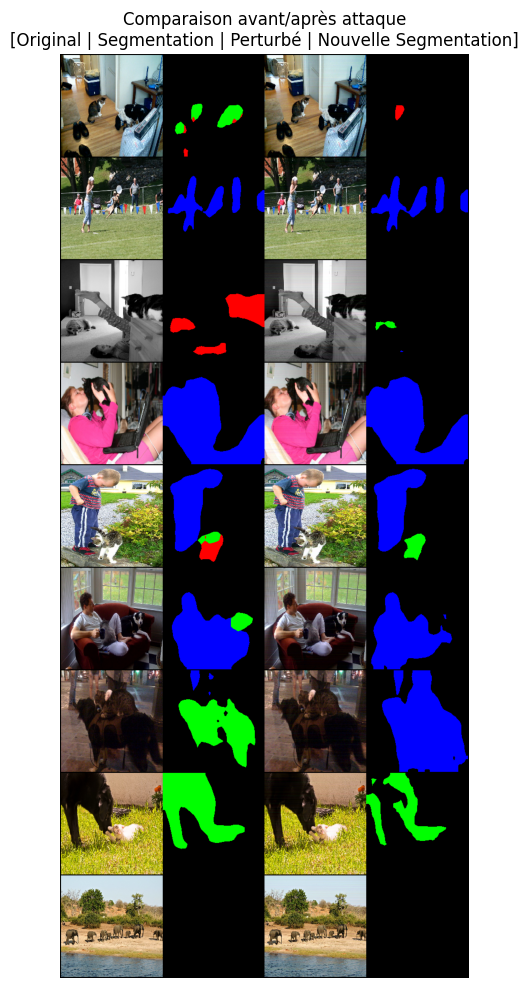

In [ ]:

# Visualisation des résultats (à définir selon vos besoins)
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().cpu()

img = load_data("coco_sample.pth")

visualize_attack_results(
    attack=attaque,
    model=net_vis,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
)

Notre attaque fournit d'assez bons résultats sur les sixième et septième images.

Etude de la transférabilité

<ipython-input-8-57a68222913e>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


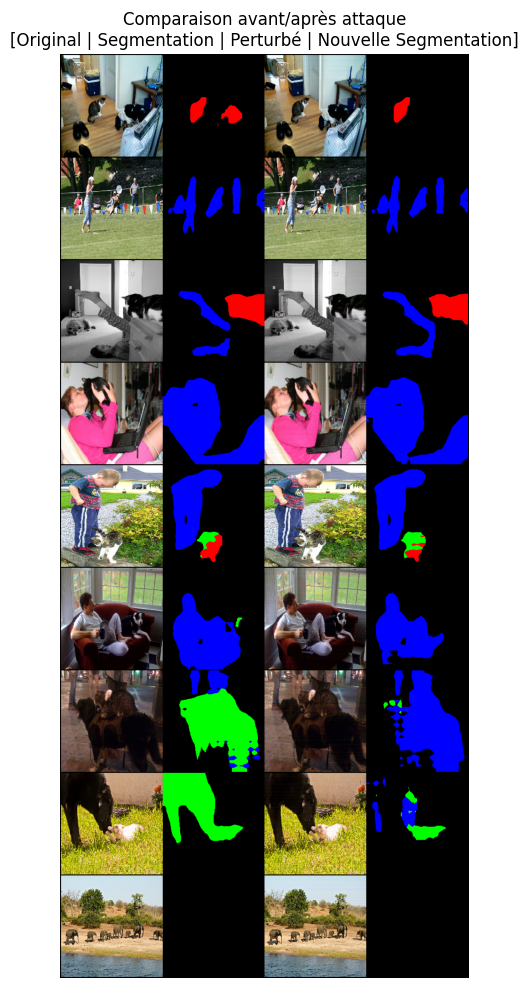

In [ ]:

# Visualisation des résultats (à définir selon vos besoins)
seg_model = torchvision.models.segmentation.fcn_resnet50(weights="DEFAULT").cpu().eval()

img = load_data("coco_sample.pth")

visualize_attack_results(
    attack=attaque,
    model=seg_model,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
)

<ipython-input-8-57a68222913e>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


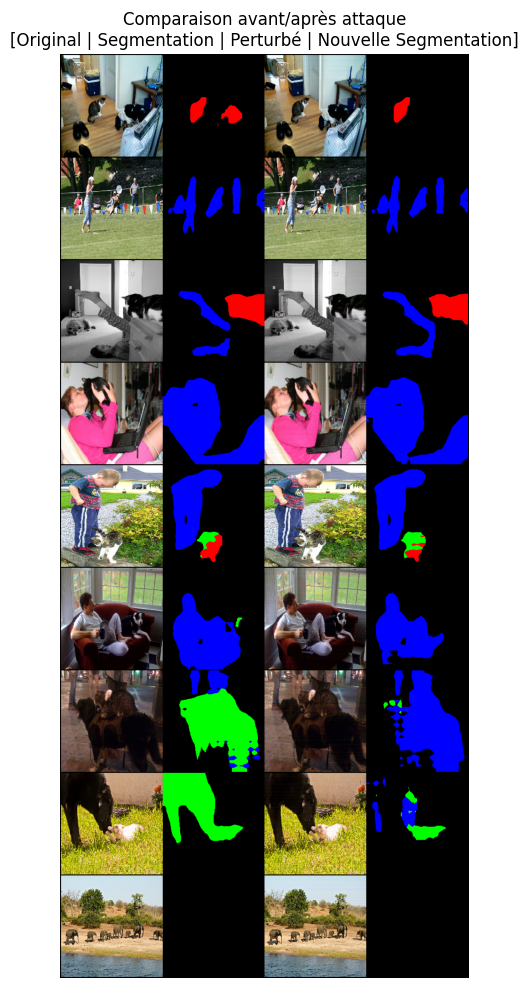

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).cpu().eval()

img = load_data("coco_sample.pth")

visualize_attack_results(
    attack=attaque,
    model=seg_model,
    original_image=img,
    normalize_transform=normalize,
    fig_size=(20, 12),
    title="Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]",
      device=torch.device('cpu')
)

Les résultats ci dessus montrent que notre attaque est transférable sur les modèles deeplabv3_resnet50, fcn_resnet50 et deeplabv3_mobilenet_v3_large. Les performances approximativement les memes.

## **Conclusion**

TOut au long de ce projet, nous avons exploré les attaques adversariales appliquées à la segmentation d’images, en utilisant des modèles préentraînés et un jeu de données issu de MS-COCO. Nous avons réussi à générer des perturbations imperceptibles qui trompent le réseau, altérant ainsi ses prédictions.

Nos expérimentations ont permis de répondre aux objectifs fixés :

* Nous avons démontré la faisabilité d’une attaque non ciblée contre un modèle de segmentation.
* Nous avons généré des attaques ciblées conduisant à des prédictions spécifiques.
* Nous avons analysé l’impact de la norme de perturbation sur l’efficacité des attaques.
* Nous avons étudié la généralisation des attaques à d’autres architectures et leur apprentissage sur plusieurs réseaux.

Ces résultats soulignent la vulnérabilité des modèles de segmentation aux attaques adversariales et ouvrent la voie à des stratégies de défense et de robustification. Des travaux futurs pourraient inclure l’application de méthodes de défense comme l’entraînement adversarial ou la détection des perturbations.